# <html>

   

<div style="background-image: linear-gradient(to left, rgb(255, 255, 255), rgb(138, 136, 136)); width: auto; margin: 10px;">

  <img src="https://upload.wikimedia.org/wikipedia/en/thumb/f/fd/University_of_Tehran_logo.svg/225px-University_of_Tehran_logo.svg.png" width=100px width=auto style="padding:10px; vertical-align: center;">



</div>

   

<div   style:"text-align: center; background-image: linear-gradient(to left, rgb(255, 255, 255), rgb( 219, 204, 245  ));width: 400px; height: 30px; ">

<h1 style="font-family: Georgia; color: black; text-align: center; ">Course: NNDL </h1>



</div>

<div   style:"border: 3px solid green;text-align: center; ">

<h1 style="font-family: Georgia; color: black; text-align: center; ">Project4 - Question1 </h1>



</div>



   <div>    

<h1 style="font-family: Georgia; color: black; text-align: center; font-size:15px;">Mohammad Amanlou- sid:810100084 </h1>
<h1 style="font-family: Georgia; color: black; text-align: center; font-size:15px;">Mohammad Mahdi Kabi- sid:810102561 </h1>





</div>

   



</html>

### Essential libraries


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from hazm import Normalizer, word_tokenize, stopwords_list
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModel
import torch
from sklearn.decomposition import TruncatedSVD
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay

In [2]:
file_path = "/content/emails.csv"

# Load the dataset
df = pd.read_csv(file_path)

# Display the first 5 rows
print(df.head())


                                                text label
0  ﻿ممنون آقا سامان.\nمن پارسال اصلا آزاد شرکت نک...   ham
1  ﻿سلام آقای کریمی\nبالاخره آزمونارشد تموم شد من...   ham
2  ﻿درود بر حاج وحیدی بنده بعنوان یک دکتری تاریخ ...   ham
3  ﻿با سلام  و احترام\nضمن تقدیر از مسولین محترم ...   ham
4  ﻿با سلام اینجانب یک دستگاه خودرو پراید 131 با ...   ham


Class Distribution:
label
ham     500
spam    500
Name: count, dtype: int64


<ipython-input-3-672d1b73095d>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')


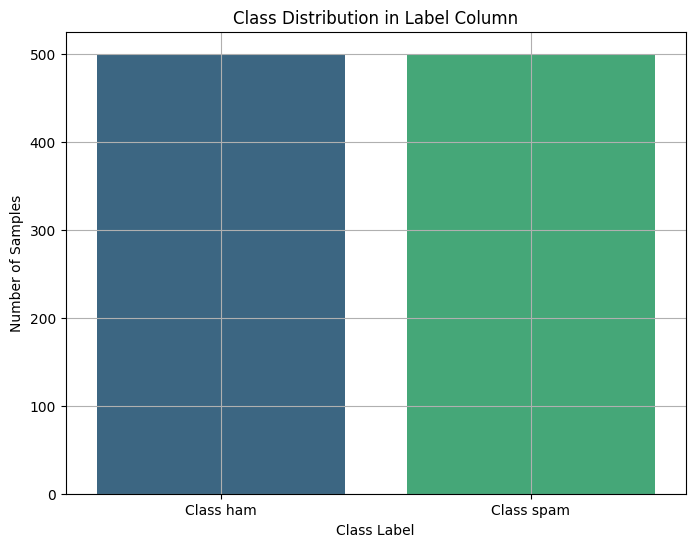

In [3]:
# Load Dataset
input_path = '/content/emails.csv'
df = pd.read_csv(input_path)

# Check if 'label' column exists
if 'label' not in df.columns:
    raise ValueError("The dataset must contain a 'label' column.")

# Count samples in each class
class_counts = df['label'].value_counts()

# Print class counts
print("Class Distribution:")
print(class_counts)

# Plot class distribution
plt.figure(figsize=(8, 6))
sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')

# Add labels and title
plt.xlabel('Class Label')
plt.ylabel('Number of Samples')
plt.title('Class Distribution in Label Column')
plt.xticks(ticks=class_counts.index, labels=[f'Class {i}' for i in class_counts.index])
plt.grid(True)
plt.show()


In [ ]:
! pip install hazm

### Preprocessing

In [5]:
input_path = '/content/emails.csv'
output_path = '/content/emails_Preproccesing.csv'

df = pd.read_csv(input_path)

# Ensure 'text' and 'label' columns exist
if 'text' not in df.columns or 'label' not in df.columns:
    raise ValueError("The dataset must contain 'text' and 'label' columns.")

# Initialize Normalizer and Stopwords
normalizer = Normalizer()
stopwords = set(stopwords_list())

# Preprocessing Function
def preprocess_text(text):
    # Normalize text
    text = normalizer.normalize(text)

    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)

    # Remove email addresses
    text = re.sub(r'\b[\w.%+-]+@[a-zA-Z.-]+\.[a-zA-Z]{2,}\b', '', text)

    # Remove phone numbers
    text = re.sub(r'\b\d{2,4}[-\s]?\d{3,4}[-\s]?\d{4}\b', '', text)

    # Reduce repeated characters
    text = re.sub(r'(.)\1{2,}', r'\1', text)

    # Tokenize and remove stopwords
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stopwords]

    # Join tokens back into a single string
    return ' '.join(tokens)

# Apply Preprocessing
df['processed_text'] = df['text'].apply(preprocess_text)

# Save Processed Dataset
df.to_csv(output_path, index=False)

print(f"Processed dataset saved at: {output_path}")


Processed dataset saved at: /content/emails_Preproccesing.csv


### Feature Extraction

In [6]:
# Load Preprocessed Dataset
input_path = '/content/emails_Preproccesing.csv'
output_path = '/content/emails_feature.csv'

df = pd.read_csv(input_path)

# Ensure 'processed_text' column exists
if 'processed_text' not in df.columns or 'label' not in df.columns:
    raise ValueError("The dataset must contain 'processed_text' and 'label' columns.")

# Drop missing values
df = df.dropna(subset=['processed_text', 'label'])

# Initialize ParsBERT Tokenizer and Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tokenizer = AutoTokenizer.from_pretrained('HooshvareLab/bert-fa-base-uncased')
model = AutoModel.from_pretrained('HooshvareLab/bert-fa-base-uncased').to(device)

# Batch Processing for embeddings
def extract_batch_embeddings(texts, batch_size=32):
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(batch_texts.tolist(), return_tensors='pt', padding='max_length', truncation=True, max_length=32).to(device)
        outputs = model(**inputs)
        batch_embeddings = outputs.last_hidden_state[:, 0, :].detach().cpu().numpy()
        embeddings.append(batch_embeddings)
    return np.vstack(embeddings)

# Generate embeddings for the entire dataset
embeddings = extract_batch_embeddings(df['processed_text'])

# Dimensionality Reduction
n_components = min(120, embeddings.shape[0])  # Ensure valid dimension size
svd = TruncatedSVD(n_components=n_components)
reduced_features = svd.fit_transform(embeddings)

# Create Features DataFrame
features_df = pd.DataFrame(reduced_features)
features_df['label'] = df['label']

# Save Features Dataset
features_df.to_csv(output_path, index=False)

# Final report
print(f"Features dataset saved at: {output_path}")
print(f"Shape of reduced features: {reduced_features.shape}")
print("Sample features:")
print(reduced_features[:5])


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/440 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.20M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/654M [00:00<?, ?B/s]

Features dataset saved at: /content/emails_feature.csv
Shape of reduced features: (1000, 120)
Sample features:
[[-1.77798214e+01  1.22755852e+01  2.29085898e+00  4.14585495e+00
  -2.62227106e+00  1.68154871e+00 -3.15496475e-01  1.13095808e+00
  -1.34742355e+00  4.17862207e-01 -1.48142946e+00 -1.20180511e+00
  -1.38223755e+00 -1.65254176e+00  1.13501787e+00  1.06414831e+00
  -9.00564492e-02 -1.38900554e+00  1.36728668e+00 -1.20754516e+00
   5.03512740e-01  9.44951057e-01 -9.30123985e-01 -1.38980019e+00
  -1.48166463e-01 -1.89773858e-01 -7.92339146e-01  2.34849215e+00
   6.98961496e-01  9.72710609e-01 -8.76188338e-01  2.39315450e-01
   4.61861730e-01  1.36540473e+00  4.61121231e-01 -2.75960565e-01
  -1.97825670e+00  5.26897430e-01  3.13397288e-01 -1.28576684e+00
  -4.47965443e-01  4.87511754e-01 -8.63099992e-01  5.15448600e-02
   8.70081127e-01 -4.46850181e-01 -1.28780842e+00  8.87654498e-02
  -1.16389871e+00  1.49448752e-01  2.78087914e-01 -5.48528850e-01
   3.33495021e-01  5.68103909e-

In [7]:
input_path = '/content/emails_feature.csv'  # Input dataset path
output_dir = '/content/dataset'  # Output directory for saving datasets

# Load the dataset
df = pd.read_csv(input_path)

# Split the dataset into features (X) and labels (y)
X = df.drop('label', axis=1)  # All columns except 'label'
y = df['label']              # Target labels

# Split the data into training (70%) and testing (30%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Further split the training data into training (80%) and validation (20%) sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

# Display the size of each set
print(f"Training set size: {len(X_train)} samples")
print(f"Validation set size: {len(X_val)} samples")
print(f"Test set size: {len(X_test)} samples")

# Save the datasets into CSV files
X_train.to_csv(output_dir + 'train_features.csv', index=False)
y_train.to_csv(output_dir + 'train_labels.csv', index=False)

X_val.to_csv(output_dir + 'val_features.csv', index=False)
y_val.to_csv(output_dir + 'val_labels.csv', index=False)

X_test.to_csv(output_dir + 'test_features.csv', index=False)
y_test.to_csv(output_dir + 'test_labels.csv', index=False)

print("Datasets saved successfully in:", output_dir)


Training set size: 560 samples
Validation set size: 140 samples
Test set size: 300 samples
Datasets saved successfully in: /content/dataset


### CNN-LSTM

Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step - accuracy: 0.5259 - loss: 0.6939 - val_accuracy: 0.5000 - val_loss: 0.6933
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4695 - loss: 0.6944 - val_accuracy: 0.5000 - val_loss: 0.6930
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5024 - loss: 0.6923 - val_accuracy: 0.5000 - val_loss: 0.6928
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5109 - loss: 0.6930 - val_accuracy: 0.5429 - val_loss: 0.6928
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5130 - loss: 0.6930 - val_accuracy: 0.4786 - val_loss: 0.6927
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5330 - loss: 0.6921 - val_accuracy: 0.5929 - val_loss: 0.6923
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5049 - loss: 0.6921 - val_accuracy: 0.5000 - val_loss: 0.6925
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5309 - loss: 0.6911 - val_accuracy: 0.4929 - val_loss:

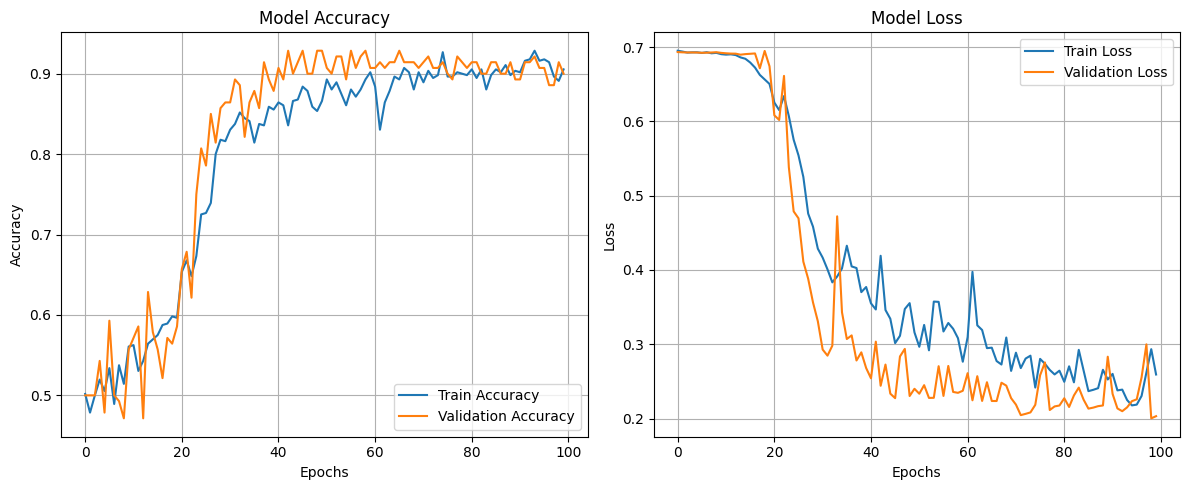

In [8]:
path = '/content/'
X_train = pd.read_csv(path + 'datasettrain_features.csv').values
y_train = pd.read_csv(path + 'datasettrain_labels.csv').values
X_val = pd.read_csv(path + 'datasetval_features.csv').values
y_val = pd.read_csv(path + 'datasetval_labels.csv').values

# Normalize data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# Convert labels
y_train = np.where(y_train == 'spam', 1, 0).astype('float32')
y_val = np.where(y_val == 'spam', 1, 0).astype('float32')

# Define model
model = Sequential()
model.add(Embedding(input_dim=6000, output_dim=64))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.5))
model.add(LSTM(64))
model.add(Dense(1, activation='sigmoid'))

# Compile model
optimizer = Adam(learning_rate=0.001)  # Reduced learning rate
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train model without Early Stopping
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=64,
    verbose=1
)

print("Model saved successfully!")

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Show the plots
plt.tight_layout()
plt.show()


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
Accuracy: 0.8467
Precision: 0.8250
Recall: 0.8800
F1 Score: 0.8516


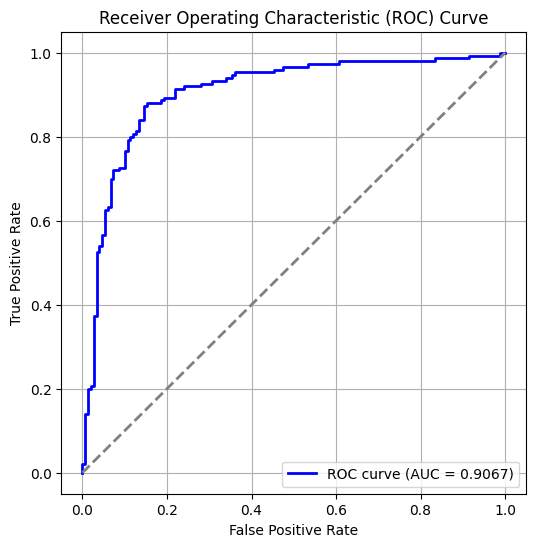

<Figure size 600x600 with 0 Axes>

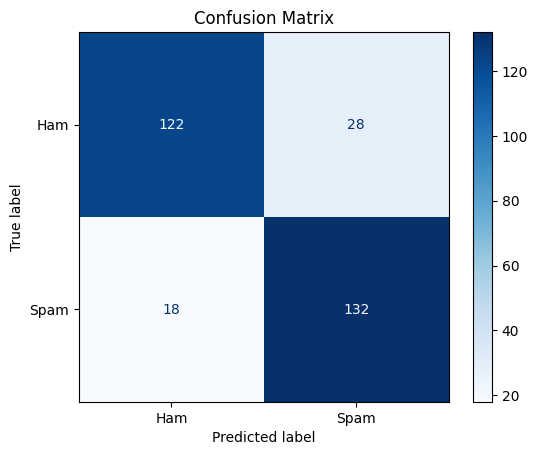

In [9]:
path = '/content/'
X_test = pd.read_csv(path + 'datasettest_features.csv').values
y_test = pd.read_csv(path + 'datasettest_labels.csv').values

# Normalize test data
X_test = scaler.transform(X_test)

# Convert labels to binary
y_test = np.where(y_test == 'spam', 1, 0).astype('float32')

# Predict probabilities and classes
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)  # Apply threshold 0.5 for binary classification

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

# -------------------------------------------
# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')  # Random classifier
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# -------------------------------------------
# Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Ham', 'Spam'])
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()


### CNN Model

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 502ms/step - accuracy: 0.4562 - loss: 0.6960 - val_accuracy: 0.6357 - val_loss: 0.6892
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.6279 - loss: 0.6863 - val_accuracy: 0.7286 - val_loss: 0.6838
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7303 - loss: 0.6764 - val_accuracy: 0.7571 - val_loss: 0.6750
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7571 - loss: 0.6581 - val_accuracy: 0.7214 - val_loss: 0.6584
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7669 - loss: 0.6353 - val_accuracy: 0.7500 - val_loss: 0.6333
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8197 - loss: 0.5902 - val_accuracy: 0.7500 - val_loss: 0.5929
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8380 - loss: 0.5254 - val_accuracy: 0.7643 - val_loss: 0.5430
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8320 - loss: 0.4611 - val_accuracy: 0.7786 - val_loss: 0.4922
Epoch 9/10

CNN Model saved successfully!


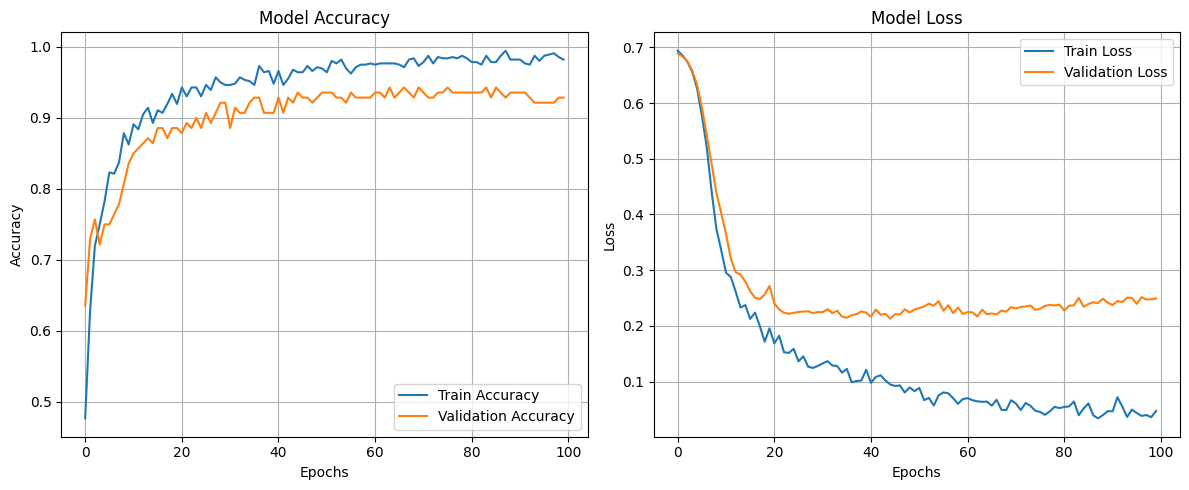

In [35]:
path = '/content/'
X_train = pd.read_csv(path + 'datasettrain_features.csv').values
y_train = pd.read_csv(path + 'datasettrain_labels.csv').values
X_val = pd.read_csv(path + 'datasetval_features.csv').values
y_val = pd.read_csv(path + 'datasetval_labels.csv').values

# --------------------------
# Normalize data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# --------------------------
# Convert labels
y_train = np.where(y_train == 'spam', 1, 0).astype('float32')
y_val = np.where(y_val == 'spam', 1, 0).astype('float32')

# --------------------------
# Define CNN model
model = Sequential()

# Embedding Layer
model.add(Embedding(input_dim=6000, output_dim=64, input_length=150))

# Convolutional Layer
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))

# Max Pooling Layer
model.add(MaxPooling1D(pool_size=2))

# Dropout Layer (to prevent overfitting)
model.add(Dropout(0.5))

# Flatten Layer
model.add(Flatten())

# Dense Output Layer
model.add(Dense(1, activation='sigmoid'))

# --------------------------
# Compile model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# --------------------------
# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=64,
    verbose=1
)

# Save the model
model.save('/content/cnn_model.h5')
print("CNN Model saved successfully!")

# --------------------------
# Plot Accuracy and Loss
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
Accuracy: 0.8767
Precision: 0.8897
Recall: 0.8600
F1 Score: 0.8746


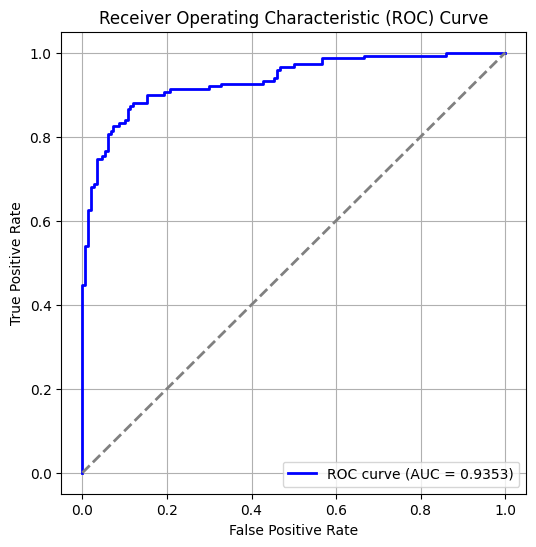

<Figure size 600x600 with 0 Axes>

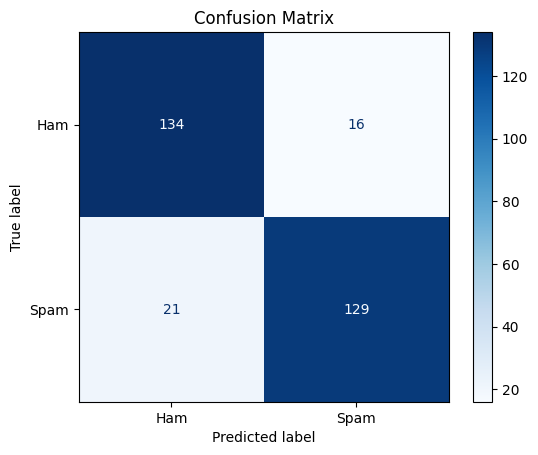

In [36]:
path = '/content/'
X_test = pd.read_csv(path + 'datasettest_features.csv').values
y_test = pd.read_csv(path + 'datasettest_labels.csv').values

# Normalize test data (using the same scaler)
X_test = scaler.transform(X_test)

# Convert labels to binary
y_test = np.where(y_test == 'spam', 1, 0).astype('float32')

# --------------------------
# Predict probabilities and classes
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)  # Apply threshold 0.5 for binary classification

# --------------------------
# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# --------------------------
# Print metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

# --------------------------
# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')  # Random classifier
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# --------------------------
# Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Ham', 'Spam'])
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()


### LSTM Model

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.4741 - loss: 0.6945 - val_accuracy: 0.4929 - val_loss: 0.6939
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5011 - loss: 0.6923 - val_accuracy: 0.4857 - val_loss: 0.6940
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5569 - loss: 0.6917 - val_accuracy: 0.4429 - val_loss: 0.6948
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5541 - loss: 0.6905 - val_accuracy: 0.4643 - val_loss: 0.6957
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5604 - loss: 0.6895 - val_accuracy: 0.4857 - val_loss: 0.6987
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5413 - loss: 0.6859 - val_accuracy: 0.5000 - val_loss: 0.7004
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5664 - loss: 0.6845 - val_accuracy: 0.4929 - val_loss: 0.7027
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5466 - loss: 0.6829 - val_accuracy: 0.4714 - val_loss: 0.7045
Epoc

LSTM Model saved successfully!


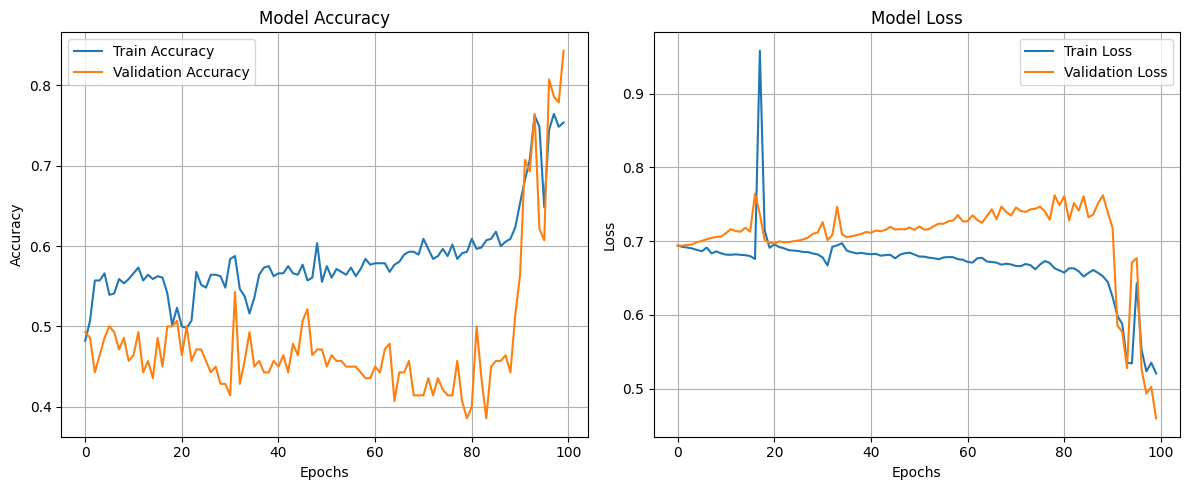

In [39]:
# Load data
path = '/content/'
X_train = pd.read_csv(path + 'datasettrain_features.csv').values
y_train = pd.read_csv(path + 'datasettrain_labels.csv').values
X_val = pd.read_csv(path + 'datasetval_features.csv').values
y_val = pd.read_csv(path + 'datasetval_labels.csv').values

# --------------------------
# Normalize data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# --------------------------
# Convert labels
y_train = np.where(y_train == 'spam', 1, 0).astype('float32')
y_val = np.where(y_val == 'spam', 1, 0).astype('float32')

# --------------------------
# Define LSTM Model
model = Sequential()

# Embedding Layer
model.add(Embedding(input_dim=6000, output_dim=64, input_length=150))  # Embedding layer

# LSTM Layer
model.add(LSTM(64))  # LSTM layer

# Dense Output Layer
model.add(Dense(1, activation='sigmoid'))  # Output layer

# --------------------------
# Compile model
optimizer = Adam(learning_rate=0.001)  # Learning rate = 0.001
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# --------------------------
# Train model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=64,
    verbose=1
)

# Save the model
model.save('/content/lstm_model.h5')
print("LSTM Model saved successfully!")

# --------------------------
# Plot Accuracy and Loss
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Accuracy: 0.7233
Precision: 0.6772
Recall: 0.8533
F1 Score: 0.7552


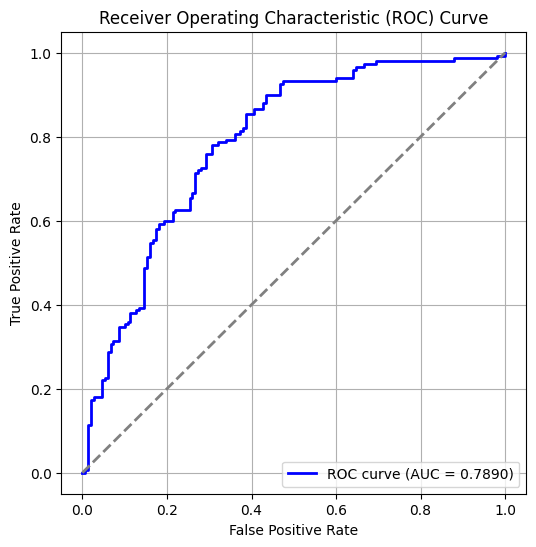

<Figure size 600x600 with 0 Axes>

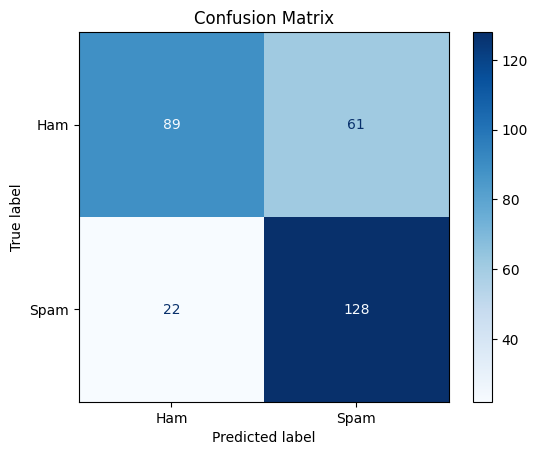

In [40]:
path = '/content/'
X_test = pd.read_csv(path + 'datasettest_features.csv').values
y_test = pd.read_csv(path + 'datasettest_labels.csv').values

# Normalize test data (using the same scaler as training)
X_test = scaler.transform(X_test)

# Convert labels to binary
y_test = np.where(y_test == 'spam', 1, 0).astype('float32')

# --------------------------
# Load the trained model
from tensorflow.keras.models import load_model
model = load_model('/content/lstm_model.h5')

# --------------------------
# Predict probabilities and classes
y_pred_prob = model.predict(X_test)  # Probabilities
y_pred = (y_pred_prob > 0.5).astype(int)  # Binary predictions (threshold = 0.5)

# --------------------------
# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# --------------------------
# Print metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

# --------------------------
# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')  # Random classifier
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# --------------------------
# Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Ham', 'Spam'])
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()
